<a href="https://colab.research.google.com/github/IorioDiego/SOA-HPC/blob/master/HPC/Cuaderno_1_Miercoles__grupo11_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introducción**

El objetivo de este ejercicio es aplicarle a una imagen un filtro por medio de lenguaje Python.

Este filtro se llama Darkening Filter, consiste en oscurecer la imagen de acuerdo a un determinado porcentaje.

En ciertos casos, cuando la luz de la imagen es demasiada, la imagen parece ser mas clara de lo esperado. Darkening Filter puede ser usado para reducir el efecto de la luz reduciendo la intensidad de los pixeles de la imagen.

Se utiliza esta formula: 

G(x, y) = f(x, y) * b; 

Donde:
f: Imagen que se filtrara
G: Imagen filtrada
x: Coordenada X de un pixel de la imagen
y: Coordenada X de un pixel de la imagen
b: Debe valer entre 0 y 1, y es constante para todos los pixeles

El objetivo es enseñar el funcionamiento del Lenguaje Python y el manejo de Google Colab.

Para cada porcentaje de b se logra observar que la ejecucion secuencial, en la cual el CPU se encarga de realizar todo el procesamiento, es mas lenta que la ejecución en paralelo, en la cual se designa el procesamiento a hilos que se ejecutaran en paralelo, haciendo la ejecucion mas rapida.

**Bibliografía**



---
# 1 Introducción




El Sobel Filter permite detectar los bordes de una imagenes valiendose de 2 matrices que utiliza para determinar el gradiente correspondiente a cada Piexel(Gx para direcciones horizontales y Gy para verticales)

Mx =  { [ -1  -2    -1] 
        [ 0    0     0]
        [ 1    2     1] }

My =  { [ -1  0  1] 
        [ -2  0  2 ]
        [ -1  2  1] } 

El gradiente se calcula a partir de : 

G(x,y) = sqrt( Gx^2 + Gy^2 )








                                    


---
# 2 Armado del ambiente
Toma la direcciòn web de una imagen con acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

In [1]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://justin-liang.com/tutorials/canny/images/3_gaussian.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg



--2021-11-22 18:23:39--  https://justin-liang.com/tutorials/canny/images/3_gaussian.jpg?raw=true
Resolving justin-liang.com (justin-liang.com)... 204.44.192.35
Connecting to justin-liang.com (justin-liang.com)|204.44.192.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22970 (22K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  22.43K  --.-KB/s    in 0.1s    

2021-11-22 18:23:40 (156 KB/s) - ‘imagen.jpg’ saved [22970/22970]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [3]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 11.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 71, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 104, in main
    return self._main(args)
  File "/usr/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/command_context.py", line 22, in main_context
    yield
  File "/usr/lib/python3.7/contextlib.py", line 524, in __exit__
    raise exc_details[1]
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.7/dist-packages/pip/

---
# 3.1 Desarrollo GPU


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
kernel.cu(7): warning: variable "idx" was declared but never referenced

kernel.cu(8): warning: variable "idy" was declared but never referenced




Imagen del filtro: imagen.jpg -L- [480, 480]
Thread: [ 16 , 19  ], Bloque : [ 30 , 26 ]
Total de Thread: [ 480 , 494  ]  =  237120
Tiempo TOTAL:  988.351 [ms]
Tiempo GPU  :  2.152 [ms]


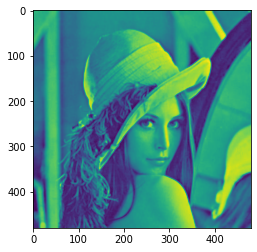

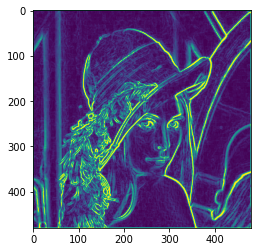

In [5]:
%matplotlib inline
from datetime import datetime
tiempo_total_GPU = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 

try:
  import pycuda.driver as cuda
except ModuleNotFoundError:
  print(Fore.RED,"No tiene el modulo cuda instalado, se instalará a continuacion")
  !pip install pycuda
  import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule


# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open(img_nombre) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu =  cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu =cuda.mem_alloc( img_R_cpu.nbytes )


# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int  *img_R )
{

   
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  int col = blockIdx .x * blockDim .x + threadIdx .x;
 int row = blockIdx .y * blockDim .y + threadIdx .y;

              if( col < ancho && row < alto ){
          int Gx [3][3] = { -1 , 0 , 1 ,
          -2 , 0 , 2 ,
          -1 , 0 , 1};

          int Gy [3][3] = {1 ,2 ,1 ,
          0 ,0 ,0 ,
          -1 , -2 , -1};

          int sumX , sumY ;
          sumX = sumY = 0;

          for (int i= -1; i <= 1; i++) {
          for (int j= -1; j <=1; j++) {
            
          

          int curPixel = img_O [( row + j) * ancho + (col + i) ];
          sumX += curPixel * Gx[i +1][ j +1];
          sumY += curPixel * Gy[i +1][ j +1];
        }
 }

 int sum = abs( sumY ) + abs( sumX ) ;
    if (sum > 255) sum = 255;
     if (sum < 0) sum = 0;
 img_R [row * ancho + col ] = sum ;

    }



  }

  




""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img_GPU = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img_GPU = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img_GPU = datetime.now() - tiempo_img_GPU

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total_GPU = datetime.now() - tiempo_total_GPU

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total_GPU ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img_GPU ), "[ms]" )

---
#3.2 Desarrollo CPU

Imagen del filtro: imagen.jpg -L- [480, 480]
Tiempo de conversión de imagen: 5254.135 [ms]
Tiempo Total: 5296.418 [ms]


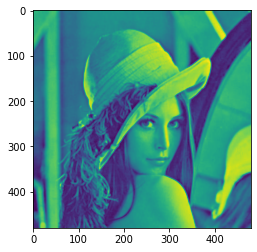

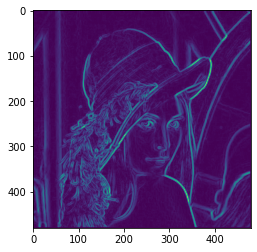

In [11]:
 %matplotlib inline
from datetime import datetime

tiempo_total_CPU = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 

  
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img_CPU = datetime.now()

# Convierto la imagen a escala de grises

# sobel_x = [ [ -1, 0, 1 ],
#       [ -2, 0, 2 ],
#       [ -1, 0, 1 ] ];

# sobel_y = [ [ -1, -2, -1 ],
#       [ 0,  0,  0 ],
#       [  1,  2,  1 ] ];


# for a  in range(0, 3 ):
#       for b  in range( 0, 3 ):
#         xn = x + a - 1;
#         yn = y + b - 1;

#         index = xn + yn * img_ancho;
#       magX += img_pic_cpu[index] * sobel_x[a][b];

sobelx = numpy.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = numpy.float)
sobely = numpy.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = numpy.float)

N = img_alto
M = img_ancho


row = img_alto
column = img_ancho
sobelxImage = numpy.zeros((row,column))
sobelyImage = numpy.zeros((row,column))
sobelGrad = numpy.zeros((row,column))

#Start time





image = numpy.pad(image, (1,1), 'edge')

for i in range(1, N-1):
    for j in range(1, M-1):        
        #Calculate gx and gy using Sobel (horizontal and vertical gradients)
        gx = (sobelx[0][0] * image[i-1][j-1]) + (sobelx[0][1] * image[i-1][j]) + \
             (sobelx[0][2] * image[i-1][j+1]) + (sobelx[1][0] * image[i][j-1]) + \
             (sobelx[1][1] * image[i][j]) + (sobelx[1][2] * image[i][j+1]) + \
             (sobelx[2][0] * image[i+1][j-1]) + (sobelx[2][1] * image[i+1][j]) + \
             (sobelx[2][2] * image[i+1][j+1])

        gy = (sobely[0][0] * image[i-1][j-1]) + (sobely[0][1] * image[i-1][j]) + \
             (sobely[0][2] * image[i-1][j+1]) + (sobely[1][0] * image[i][j-1]) + \
             (sobely[1][1] * image[i][j]) + (sobely[1][2] * image[i][j+1]) + \
             (sobely[2][0] * image[i+1][j-1]) + (sobely[2][1] * image[i+1][j]) + \
             (sobely[2][2] * image[i+1][j+1])     

    

        #Calculate the gradient magnitude
        g =numpy.sqrt(gx * gx + gy * gy)
        sobelGrad[i-1][j-1] = g


# xKernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
# yKernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
#     sobelled = numpy.zeros((img_ancho-2,img_alto[1]-2, 3), dtype="uint8")
#     for y in range(1, img_ancho-1):
#         for x in range(1, img_alto-1):
#             gx = numpy.sum(numpy.multiply(img[y-1:y+2, x-1:x+2], xKernel))
#             gy = numpy.sum(numpy.multiply(img[y-1:y+2, x-1:x+2], yKernel))
#             g = abs(gx) + abs(gy) #math.sqrt(gx ** 2 + gy ** 2) (Slower)
#             g = g if g > 0 and g < 255 else (0 if g < 0 else 255)
#             sobelled[y-1][x-2] = g




tiempo_img_CPU = datetime.now() - tiempo_img_CPU

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( sobelGrad )

tiempo_total_CPU = datetime.now() - tiempo_total_CPU

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img_CPU   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total_CPU ), "[ms]" )

---
#4.Métricas

In [27]:
print( "Tiempo TOTAL CPU  :", tiempo_en_ms( tiempo_total_CPU ), "[ms]" )
print( "Tiempo CPU        :", tiempo_en_ms( tiempo_img_CPU   ), "[ms]\n" )

print("Tiempo TOTAL GPU   : ", tiempo_en_ms( tiempo_total_GPU ), "[ms]" )
print("Tiempo GPU         : ", tiempo_en_ms( tiempo_img_GPU ), "[ms]\n" )


print("SpeedUp            : (tiempo secuencial/tiempo paralelo) : ", tiempo_en_ms(tiempo_total_CPU) , "/" , tiempo_en_ms(tiempo_total_GPU), f"={tiempo_total_CPU/tiempo_total_GPU:,.3f}" )

Tiempo TOTAL CPU  : 5296.418 [ms]
Tiempo CPU        : 5254.135 [ms]

Tiempo TOTAL GPU   :  57.843 [ms]
Tiempo GPU         :  0.223 [ms]

SpeedUp            : (tiempo secuencial/tiempo paralelo) :  5296.418 / 57.843 =91.565


###SpeedUp
Referencia a la ganacia de velocidad que se consigue con un algoritmo paralelo, al resolver el mismo problema con respecto al algoritmo secuencial.

---
#5.Conclusiones

A patir de los casos planteados para  CPU  GPU , podemos observar que el tiempo que tarda en ejectuarse el algorithmon de Soble Filter es menor en el caso de la GPU, esto se debe a que el algoritmo es ejecutado por los hilos de la GPU en forma paralela, y de manera tal que elimina la complijidad computacional de los dos fors que son utilizados en el lagormitmo secuncial para recorrer la imagen utilizada

---
#6.Bibliografía

1.	Implementation of Image Enhancement Algorithms and Recursive Ray Tracing using CUDA. Mr. Diptarup Saha , Mr. Karan Darji , Dr. Narendra Patel , Dr. Darshak Thakore. 7th International Conference on Communication, Computing and Virtualization 2016

2. Ejemplo Prueba 2 - Imagen - CPU: [Página web](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20CPU.ipynb)

3. Ejemplo Prueba 3 - Imagen - GPU: [Página web](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb)

4. Explicación y ejemplos Python: [Página web](https://docs.python.org/es/3/contents.html)